## Land Subsidence 2040

Notebook environment to migrate TIF files to CF compliant CoG

In [1]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

<IPython.core.display.Javascript object>

### Configure OS independent paths

In [2]:
#%pip uninstall coastmonitor

<IPython.core.display.Javascript object>

In [3]:
import os


# a=os.path.join(BASE_DIR, "..", "..", "pyproject.toml")

<IPython.core.display.Javascript object>

In [4]:
# Import standard packages
import os
import pathlib
import sys
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from dotenv import load_dotenv
import math
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union
import rioxarray as rio
from tqdm import tqdm
#load_dotenv()

# Import custom functionality
from coclicodata.drive_config import p_drive
from coclicodata.etl.cf_compliancy_checker import check_compliancy, save_compliancy

# use workaround because : FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\rowe\\AppData\\Local\\miniconda3\\envs\\coclico\\Lib\\site-packages\\coastmonitor\\..\\..\\pyproject.toml'
sys.path.append(r'C:\Users\rowe\Documents\GitHub\coastmonitor\src')
from coastmonitor.io.utils import name_block


# Workaround to the Windows OS (10) udunits error after installation of cfchecker: https://github.com/SciTools/iris/issues/404
os.environ["UDUNITS2_XML_PATH"] = str(
    pathlib.Path().home().joinpath(  # change to the udunits2.xml file dir in your Python installation
        r"AppData\Local\miniconda3\pkgs\udunits2-2.2.28-h892ecd3_0\Library\share\udunits\udunits2.xml" ###Changed from anaconda to miniconda  - added the new package udunits file
    )
)

gca_data_dir = p_drive.joinpath("11209197-018-global-coastal-atlas", r"MSc_students\ClenmarRowe\Data\All_Datasets", r"Orig_Datasets\01_Hazards\02_Future")


<IPython.core.display.Javascript object>

In [5]:
# Project paths & files (manual input)
dataset_dir = gca_data_dir.joinpath(r"Land_Subsidence\GSH_2040")
ds_dir=dataset_dir

dataset_dir_path = gca_data_dir.joinpath(r"Land_Subsidence\GSH_2040","GSH_2040.tif")
ds_path = dataset_dir_path

CF_dir = gca_data_dir.joinpath(r"Land_Subsidence\GSH_2040","CF")  # directory to save output CF check files

# directory to export result (make if not exists)
cog_dir = ds_dir.joinpath("cog") # for checking CF compliancy
cog_dirs = ds_dir.joinpath("cogs") # for making all files CF compliant
cog_dir.mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

### Write data to CoG

In [6]:
# NetCDF attribute alterations by means of metadata template
import json
f_global = open(ds_dir.joinpath("metadata_global_land_subsidence_2040.json"))
meta_global = json.load(f_global)

<IPython.core.display.Javascript object>

#### Single CoG test

In [7]:
def generate_slices(num_chunks: int, chunk_size: int) -> Tuple[slice, slice]:
    """Generate slices for chunk-based iteration."""
    for i in range(num_chunks):
        yield slice(i * chunk_size, (i + 1) * chunk_size)


cm = xr.open_dataset(
    ds_path, engine="rasterio", mask_and_scale=False
)  # .isel({"x":slice(0, 40000), "y":slice(0, 40000)})
cm = cm.assign_coords(band=("band", [f"B{k+1:02}" for k in range(cm.dims["band"])]))
cm = cm["band_data"].to_dataset("band")

# chunk size 
chunk_size = 2**12 # 16384, which is large, but OK for int8 datatype.

cm_chunked = cm.chunk({"x": chunk_size, "y": chunk_size})

num_x_chunks = math.ceil(cm_chunked.dims["x"] / chunk_size)
num_y_chunks = math.ceil(cm_chunked.dims["y"] / chunk_size)

for x_slice in generate_slices(num_x_chunks, chunk_size):
    for y_slice in generate_slices(num_y_chunks, chunk_size):
        chunk = cm_chunked.isel(x=x_slice, y=y_slice)

        chunk = chunk.assign_coords(time=pd.Timestamp(2010, 1, 1).isoformat())

        for var in chunk:
            da = chunk[var]

            da = (
                da.where(da != -9999, 0)
                .astype("uint8")
                .rio.write_nodata(0)
                .rio.set_spatial_dims(x_dim="x", y_dim="y")
            )

            item_name = name_block(
                da,
                storage_prefix="",
                name_prefix="",
                include_band=da.name,
                time_dim=False,
                x_dim="x",
                y_dim="y",
            )

            # convert to dataset
            dad = da.to_dataset()

            # add all attributes (again)
            for attr_name, attr_val in meta_global.items():
                if attr_name == 'PROVIDERS':
                    attr_val = json.dumps(attr_val)
                if attr_name == "MEDIA_TYPE": # change media type to tiff, leave the rest as is
                    attr_val = "IMAGE/TIFF"
                dad.attrs[attr_name] = attr_val

            dad.attrs['Conventions'] = "CF-1.8"

            # export file
            outpath = cog_dir.joinpath(item_name)
            dad.rio.to_raster(outpath, compress="DEFLATE", driver="COG")

        break
    break

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


<IPython.core.display.Javascript object>

In [8]:
# export to nc for quick CF compliancy check..
dad.to_netcdf(path=cog_dir.joinpath(item_name.replace(".tif", ".nc")))

<IPython.core.display.Javascript object>

In [9]:
a = xr.open_dataset(
    ds_path, engine="rasterio", mask_and_scale=False
) 
a

<xarray.Dataset>
Dimensions:      (band: 1, x: 43200, y: 16692)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 83.11 83.1 83.1 83.09 ... -55.96 -55.97 -55.98
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) uint8 ...

<IPython.core.display.Javascript object>

In [10]:
start_point=float(a['y'].max().values)
start_point=math.floor(start_point)
start_point

83

<IPython.core.display.Javascript object>

In [11]:
end_point=float(a['y'].min().values)
end_point=math.ceil(end_point)
end_point

-55

<IPython.core.display.Javascript object>

In [12]:
q=a.sel(y=slice(start_point,end_point))
q

<xarray.Dataset>
Dimensions:      (band: 1, x: 43200, y: 16560)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 83.0 82.99 82.98 82.97 ... -54.98 -54.99 -55.0
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) uint8 ...

<IPython.core.display.Javascript object>

In [13]:
%%capture cap --no-stderr
# check original CF compliancy

check_compliancy(testfile=cog_dir.joinpath(item_name.replace(".tif", ".nc")), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [14]:
# save original CF compliancy
save_compliancy(cap, testfile=cog_dir.joinpath(item_name.replace(".tif", ".nc")), working_dir=CF_dir)

{'P:\\11209197-018-global-coastal-atlas\\MSc_students\\ClenmarRowe\\Data\\All_Datasets\\Orig_Datasets\\01_Hazards\\02_Future\\Land_Subsidence\\GSH_2040\\cog\\B01_x-180.0_y48.99.nc': {'warnings': '8', 'errors': '1'}}


<IPython.core.display.Javascript object>

##### Note, the CF compliancy check here gives warnings & errors for the NC files because we actually did not focus on making it CF complaint. The file was delivered as TIFF and will be outputted as TIFF. Hence, there is actually no need in making a NC file. TIFFs are way less flexible in variables and therefore no CF compliancy check is needed. Data will always be an array with band, y, x as dimensions and band, y, x, spatial_ref as coordinates

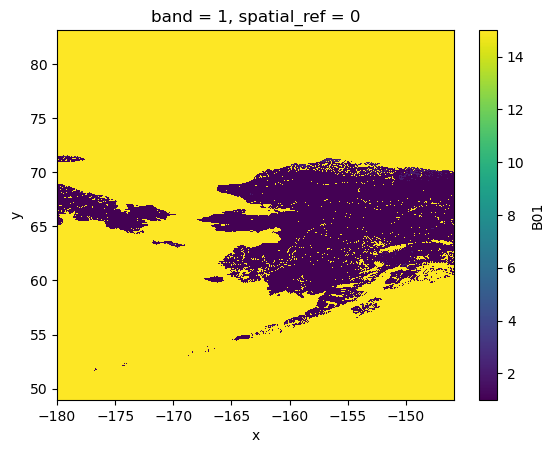

<IPython.core.display.Javascript object>

In [15]:
# plot to check output
data = rio.open_rasterio(outpath, masked=True)
data.plot()
#rds.plot()

In [16]:
data

<xarray.DataArray (band: 1, y: 4096, x: 4096)>
[16777216 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -180.0 -180.0 -180.0 ... -145.9 -145.9 -145.9
  * y            (y) float64 83.11 83.1 83.1 83.09 ... 49.01 49.0 49.0 48.99
    spatial_ref  int32 0
Attributes: (12/25)
    AREA_OR_POINT:       Area
    AUTHOR:              Gerardo Herrera-García
    CITATION:            Gerardo Herrera-García et al. , Mapping the global t...
    COMMENT:             The dataset includes classified probabilities of lan...
    Conventions:         CF-1.8
    CRS:                 EPSG:4326
    ...                  ...
    TITLE:               Potential Global Subsidence (2040)
    TITLE_ABBREVIATION:  GSH
    UNITS:               probability levels
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           B01

<IPython.core.display.Javascript object>

#### Multiple CoGs

In [18]:
from datacube.utils.cog import write_cog
def generate_slices(num_chunks: int, chunk_size: int) -> Tuple[slice, slice]:
    """Generate slices for chunk-based iteration."""
    for i in range(num_chunks):
        yield slice(i * chunk_size, (i + 1) * chunk_size)


cm = xr.open_dataset(
    ds_path, engine="rasterio", mask_and_scale=False
)  
#Shave for a neat chunk
start_point_y=float(cm['y'].max().values)
start_point_y=math.floor(start_point)
end_point_y=float(cm['y'].min().values)
end_point_y=math.ceil(end_point)

cm=cm.sel(y=slice(start_point_y,None))

cm = cm.assign_coords(band=("band", [f"B{k+1:02}" for k in range(cm.dims["band"])]))
cm = cm["band_data"].to_dataset("band")

# chunk size 
# chunk_size = 2**12 # 16384, which is large, but OK for int8 datatype.
chunk_size = 360 # Will yield 3 deg sized cogs

cm_chunked = cm.chunk({"x": chunk_size, "y": chunk_size})

num_x_chunks = math.ceil(cm_chunked.dims["x"] / chunk_size)
num_y_chunks = math.ceil(cm_chunked.dims["y"] / chunk_size)

for x_slice in tqdm(generate_slices(num_x_chunks, chunk_size),desc="Main loop completion"):
    for y_slice in generate_slices(num_y_chunks, chunk_size):
        chunk = cm_chunked.isel(x=x_slice, y=y_slice)

        chunk = chunk.assign_coords(time=pd.Timestamp(2010, 1, 1).isoformat())

        for var in chunk:
            #print(x_slice, y_slice)

            da = chunk[var]

            # da = (
            #     da.where(da != -9999, 0)
            #     .astype("uint8")
            #     .rio.write_nodata(0)
            #     .rio.set_spatial_dims(x_dim="x", y_dim="y")
            # )

            da = (
                da.rio.write_nodata(-9999)
#                .astype("uint8")
                .rio.set_spatial_dims(x_dim="x", y_dim="y")
            )            

            item_name = name_block(
                da,
                storage_prefix="",
                name_prefix="",
                include_band=da.name,
                time_dim=False,
                x_dim="x",
                y_dim="y",
            )

            #print(item_name)

            # convert to dataset
            dad = da.to_dataset()

            # add all attributes (again)
            for attr_name, attr_val in meta_global.items():
                if attr_name == 'PROVIDERS':
                    attr_val = json.dumps(attr_val)
                if attr_name == "MEDIA_TYPE": # change media type to tiff, leave the rest as is
                    attr_val = "IMAGE/TIFF"
                dad.attrs[attr_name] = attr_val

            dad.attrs['Conventions'] = "CF-1.8"

            # make parent dir if not exists
            outpath = cog_dirs.joinpath(item_name)
            outpath.parent.mkdir(parents=True, exist_ok=True)

            # export file
            dad.rio.to_raster(outpath, compress="DEFLATE", driver="COG")

            # set overwrite is false because tifs should be unique
            # try:
            #     write_cog(da, fname=outpath, overwrite=False).compute()
            # except OSError as e:
            #     continue

Main loop completion: 0it [00:00, ?it/s]c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (-9999.0) has been automatically changed to (241) to match the dtype of the data.
  warnings.warn(
c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (-9999.0) has been automatically changed to (241) to match the dtype of the data.
  warnings.warn(
c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (-9999.0) has been automatically changed to (241) to match the dtype of the data.
  warnings.warn(
c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (-9999.0) has been automatically changed to (241) to match the dtype of the data.
  warnings.warn(
c:\Users\rowe\AppData\Local\minicond

<IPython.core.display.Javascript object>

In [ ]:
# %%capture cap --no-stderr
# # check original CF compliancy

# check_compliancy(testfile=cog_dir.joinpath(item_name.replace(".tif", ".nc")), working_dir=CF_dir)

In [ ]:
# save original CF compliancy
# save_compliancy(cap, testfile=cog_dir.joinpath(item_name.replace(".tif", ".nc")), working_dir=CF_dir)